# Experiment plotting

This notebook contains the code for plotting results for the different experiments.
When run for the first time for a town, condensed summary files are being created which strongly speed up subsequent generations of plots from the same summaries. It is possible to create the plots only from the condensed summaries located in 'summaries/condensed_summaries'.
Note that this works for all experiments but the Rt plots, which still require the full summary file.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import pickle
import itertools
from lib.measures import *
from lib.experiment import Experiment, Plot, Result, get_properties, load_summary_list, load_summary
from lib.data import collect_data_from_df
from lib.calibrationSettings import calibration_lockdown_dates, calibration_start_dates, calibration_mob_paths
from lib.calibrationFunctions import get_calibrated_params, downsample_cases
import lib.plot as lib_plot
from lib.plot import Plotter
import matplotlib.pyplot as plt
from lib.summary import load_condensed_summary, get_tracing_probability
from matplotlib import colors

In [3]:
# commithash = '9ee166f'
commithash = 'a575154'

make_paper_plots = False

# Reduction of different quantities compared to baseline

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.


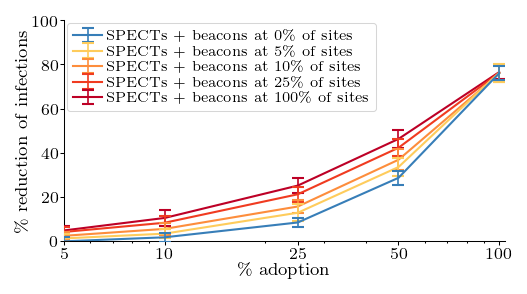

In [42]:
def plot_relative_reduction(*, country, area, mode, ps_adoption, beacon_proportions, beacon_mode='visit_freq', 
                            manual_tracing=True, show_reduction=True, show_spect_with_beacons=False,
                            isolation_cap=None, ylim=None, commithash=None):
    
    if manual_tracing:
        p_recall = 0.1
        p_manual_reachability = 0.5
    else:
        p_recall = 0.0
        p_manual_reachability = 0.0
        
    if mode == 'r_eff':
        if area == 'TU':
            from lib.settings.town_settings_tubingen import town_population
        else:
            raise NotImplementedError('Specify town population')
    else:
        town_population = None
        
    if isolation_cap is not None:
        is_site_info = '-siteinfo'
        extension = f'-isolation_cap={isolation_cap}'
    else:
        is_site_info = ''
        extension = ''
        

        
    if ylim is None:
        if mode == 'r_eff' and show_reduction:
            ylim = (0.0, 50)
        elif mode == 'r_eff' and not show_reduction:
            ylim= (1.0, 3.5)
            
    
    plot_filename = (f'comparison{is_site_info}-{mode}-{country}-{area}'
                    f'-reduction={show_reduction}'
                    f'-beacon_mode={beacon_mode}'
                    f'-manual_tracing={manual_tracing}'
                    f'-p2p+beacons={show_spect_with_beacons}')
    paths = [
                [f'PanCast/spect-tracing{is_site_info}-{country}-{area}-{commithash}/'
                 f'spect-tracing{is_site_info}-{country}-{area}'
                 f'-p_adoption={p_adoption}'
                 f'-p_recall={p_recall}'
                 f'-p_manual_reachability={p_manual_reachability}'
                 f'-delta_manual_tracing={delta_manual_tracing}'
                 f'{extension}'
                 '.pk' for p_adoption in ps_adoption]
            ]
    titles = ['SPECTs']
    
    for beacon_proportion in beacon_proportions:
        paths.append([f'PanCast/pancast-tracing{is_site_info}-{country}-{area}-{commithash}/'
                      f'pancast-tracing{is_site_info}-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-beacon_proportion={beacon_proportion}'
                      f'-beacon_mode={beacon_mode}'
                      f'-p2p_beacon={show_spect_with_beacons}'
                      f'-p_recall={p_recall}'
                      f'-p_manual_reachability={p_manual_reachability}'
                      f'-delta_manual_tracing={delta_manual_tracing}'
                      f'{extension}'
                      '.pk' for p_adoption in ps_adoption])
                     
        titles.append(f'PanCast, beacons at {int(beacon_proportion*100)}\% of sites')
    
    
    if show_spect_with_beacons:
        titles = [f'SPECTs + beacons at {int(beacon_proportion*100)}\% of sites' for beacon_proportion in ([0] + beacon_proportions[::-1])]
        new_paths = paths[1:]
        paths = [paths[0]] + new_paths[::-1]
        colors = ['#377eb8', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026']
    else:
        colors = None


    baseline_path = (f'PanCast/spect-tracing{siteinfo}-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     f'-delta_manual_tracing={delta_manual_tracing}'
                     f'{extension}'
                     f'.pk')


    plotter = Plotter()
    plotter.compare_peak_reduction(path_list=paths, 
                                   baseline_path=baseline_path, 
                                   ps_adoption=ps_adoption,
                                   area_population=town_population,
                                   titles=titles,
                                   mode=mode,
                                   show_reduction=show_reduction,
                                   log_xscale=True,
                                   ylim=ylim,
                                   colors=colors,
                                   filename=plot_filename,
                                   figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
                                   figformat='neurips-double',
                                   legend_is_left=True)


    
if make_paper_plots:
    # Main results section, manual tracing panel
    plot_relative_reduction(
        country='GER', 
        area='TU', 
        mode='cumu_infected',
        ps_adoption=[1.0, 0.5, 0.25, 0.1, 0.05],
        beacon_proportions=[1.0, 0.25, 0.1, 0.05],
        beacon_mode='visit_freq',
        manual_tracing=True,
        show_spect_with_beacons=False,
        commithash=commithash
    )
    
    # Main results section, environmental information
    plot_relative_reduction(
        country='GER', 
        area='TU', 
        mode='cumu_infected',
        ps_adoption=[1.0, 0.5, 0.25, 0.1, 0.05],
        beacon_proportions=[1.0, 0.25, 0.1, 0.05],
        isolation_cap=0.05, # TUNE THIS
        manual_tracing=True, # DISCUSS
        show_spect_with_beacons=False,
        commithash=commithash
    )
    
    # SI results section, manual tracing sensitivity analysis, PanCast, Spects without manual
    plot_relative_reduction(
        country='GER', 
        area='TU', 
        mode='cumu_infected',
        ps_adoption=[1.0, 0.5, 0.25, 0.1, 0.05],
        beacon_proportions=[1.0, 0.25, 0.1, 0.05],
        manual_tracing=False,
        show_spect_with_beacons=False,
        commithash=commithash
    )
    
    # SI results section, interoperability
    plot_relative_reduction(
        country='GER', 
        area='TU', 
        mode='cumu_infected',
        ps_adoption=[1.0, 0.5, 0.25, 0.1, 0.05],
        beacon_proportions=[1.0, 0.25, 0.1, 0.05],
        manual_tracing=True,
        show_spect_with_beacons=True,
        commithash=commithash
    )

else:
    
    plot_relative_reduction(
        country='GER', 
        area='TU', 
        mode='cumu_infected',   # Allowed values ['cumu_infected', 'hosp', 'dead', 'r_eff']
        ps_adoption=[1.0, 0.5, 0.25, 0.1, 0.05],
        beacon_proportions=[1.0, 0.25, 0.1, 0.05],#, 0.02],
        manual_tracing=True,
        show_spect_with_beacons=True,
        show_reduction=True,
        commithash=commithash
    )

## SI: Environmental information, isolation caps

In [ ]:
def plot_relative_reduction_isolation_cap(*, country, area, mode, ps_adoption, beacon_proportion, beacon_mode='visit_freq', 
                            manual_tracing=True, show_reduction=True, show_spect_with_beacons=False,
                            isolation_caps=None, ylim=None, commithash=None):
    
    if manual_tracing:
        p_recall = 0.1
        p_manual_reachability = 0.5
    else:
        p_recall = 0.0
        p_manual_reachability = 0.0
        
    if mode == 'r_eff':
        if area == 'TU':
            from lib.settings.town_settings_tubingen import town_population
        else:
            raise NotImplementedError('Specify town population')
    else:
        town_population = None
        
        
    if ylim is None:
        if mode == 'r_eff' and show_reduction:
            ylim = (0.0, 50)
        elif mode == 'r_eff' and not show_reduction:
            ylim= (1.0, 3.5)
            
    
    plot_filename = (f'comparison-isolation-caps-{mode}-{country}-{area}'
                    f'-reduction={show_reduction}'
                    f'-beacon_mode={beacon_mode}'
                    f'-manual_tracing={manual_tracing}'
                    f'-p2p+beacons={show_spect_with_beacons}')
    
    
    paths = []
    titles = []
    
    for cap in isolation_caps:
        paths = [
                    [f'PanCast/spect-tracing-siteinfo-{country}-{area}-{commithash}/'
                     f'spect-tracing{is_site_info}-{country}-{area}'
                     f'-p_adoption={p_adoption}'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     f'-delta_manual_tracing={delta_manual_tracing}'
                     f'-isolation_cap={cap}'
                     '.pk' for p_adoption in ps_adoption]
                ]
        titles.append(f'SPECTS, isolation cap {int(cap*100)}\%')
    
    for cap in isolation_caps:
        paths.append([f'PanCast/pancast-tracing-siteinfo-{country}-{area}-{commithash}/'
                      f'pancast-tracing{is_site_info}-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-beacon_proportion={beacon_proportion}'
                      f'-beacon_mode={beacon_mode}'
                      f'-p2p_beacon={show_spect_with_beacons}'
                      f'-p_recall={p_recall}'
                      f'-p_manual_reachability={p_manual_reachability}'
                      f'-delta_manual_tracing={delta_manual_tracing}'
                      f'-isolation_cap={cap}'
                      '.pk' for p_adoption in ps_adoption])
                     
        titles.append(f'PanCast, {int(beacon_proportion*100)}\% beacons, isolation cap {int(cap*100)}\%')


    baseline_path = (f'PanCast/spect-tracing-siteinfo-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     f'-delta_manual_tracing={delta_manual_tracing}'
                     f'-isolation_cap={cap}'
                     f'.pk')


    plotter = Plotter()
    plotter.compare_peak_reduction(path_list=paths, 
                                   baseline_path=baseline_path, 
                                   ps_adoption=ps_adoption,
                                   area_population=town_population,
                                   titles=titles,
                                   mode=mode,
                                   show_reduction=show_reduction,
                                   log_xscale=True,
                                   ylim=ylim,
                                   colors=None,
                                   filename=plot_filename,
                                   figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
                                   figformat='neurips-double',
                                   legend_is_left=True)


    
if make_paper_plots:
    # SI results section, environmental information, dependence on isolation caps
    plot_relative_reduction_isolation_cap(
        country='GER', 
        area='TU', 
        mode='cumu_infected',
        ps_adoption=[1.0, 0.5, 0.25, 0.1, 0.05],
        beacon_proportion=0.25,
        isolation_caps=[0.1, 0.05, 0.02, 0.01, 0.005],
        manual_tracing=True,
        commithash=commithash
    )

## SI: Manual tracing delay

In [ ]:
def plot_relative_reduction_manual_tracing_delay(*, country, area, mode, ps_adoption, manual_tracing_delays, 
                                                 beacon_proportion, beacon_mode='visit_freq', 
                                                 show_reduction=True, show_spect_with_beacons=False, 
                                                 ylim=None, commithash=None):
    
    p_recall = 0.1
    p_manual_reachability = 0.5
        
    if mode == 'r_eff':
        if area == 'TU':
            from lib.settings.town_settings_tubingen import town_population
        else:
            raise NotImplementedError('Specify town population')
    else:
        town_population = None
        
        
    if ylim is None:
        if mode == 'r_eff' and show_reduction:
            ylim = (0.0, 50)
        elif mode == 'r_eff' and not show_reduction:
            ylim= (1.0, 3.5)
            
    
    plot_filename = (f'comparison-manual-tracing_delay-{mode}-{country}-{area}'
                    f'-reduction={show_reduction}')
    
    
    paths = []
    titles = []
    
    for delta_manual_tracing in manual_tracing_delays:
        paths = [
                    [f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing{is_site_info}-{country}-{area}'
                     f'-p_adoption={p_adoption}'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     f'-delta_manual_tracing={delta_manual_tracing}'
                     '.pk' for p_adoption in ps_adoption]
                ]
        titles.append(f'SPECTS, {int(delta_manual_tracing)} hours delay')
    
    for delta_manual_tracing in manual_tracing_delays:
        paths.append([f'PanCast/pancast-tracing-{country}-{area}-{commithash}/'
                      f'pancast-tracing{is_site_info}-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-beacon_proportion={beacon_proportion}'
                      f'-beacon_mode={beacon_mode}'
                      f'-p2p_beacon={show_spect_with_beacons}'
                      f'-p_recall={p_recall}'
                      f'-p_manual_reachability={p_manual_reachability}'
                      f'-delta_manual_tracing={delta_manual_tracing}'
                      '.pk' for p_adoption in ps_adoption])
                     
        titles.append(f'PanCast, {int(beacon_proportion*100)}\% beacons, {int(delta_manual_tracing)} hours delay')


    baseline_path = (f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall=0.0'
                     f'-p_manual_reachability=0.0'
                     f'-delta_manual_tracing=0.0'
                     f'.pk')


    plotter = Plotter()
    plotter.compare_peak_reduction(path_list=paths, 
                                   baseline_path=baseline_path, 
                                   ps_adoption=ps_adoption,
                                   area_population=town_population,
                                   titles=titles,
                                   mode=mode,
                                   show_reduction=show_reduction,
                                   log_xscale=True,
                                   ylim=ylim,
                                   colors=None,
                                   filename=plot_filename,
                                   figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
                                   figformat='neurips-double',
                                   legend_is_left=True)


    
if make_paper_plots:
    # SI results section, effect of manual tracing delays compared to no manual tracing baseline
    plot_relative_reduction_isolation_cap(
        country='GER', 
        area='TU', 
        mode='cumu_infected',
        ps_adoption=[1.0, 0.5, 0.25, 0.1, 0.05],
        beacon_proportion=0.25,
        manual_tracing_delays=[0.0, 12.0, 24.0],
        commithash=commithash
    )

# Quantities over time

## Main results, Manual tracing helps with low adoption

Extracting data from summary: PanCast/spect-tracing-GER-TU-None/spect-tracing-GER-TU-p_adoption=0.0-p_recall=0.1-p_manual_reachability=0.5.pk


FileNotFoundError: [Errno 2] No such file or directory: 'summaries/PanCast/spect-tracing-GER-TU-None/spect-tracing-GER-TU-p_adoption=0.0-p_recall=0.1-p_manual_reachability=0.5.pk'

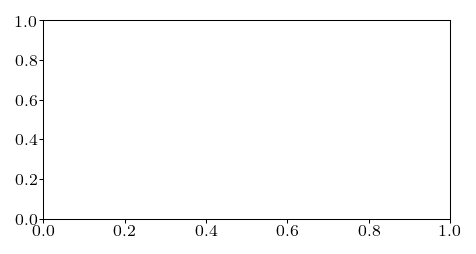

In [32]:
def plot_over_time_section_manual(*, country, area, quantity, mode, beacon_proportions, p_adoption=0.25, ymax, 
                                  rt_plots=True, commithash=None):

    p_recall = 0.1
    p_manual_reachability = 0.5
    delta_manual_tracing = 0.0
    show_spect_with_beacons = False
    beacon_mode = 'visit_freq'

    
    paths = [f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall=0.1'
                     f'-p_manual_reachability=0.5'
                     '.pk',
             
             f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
                 f'spect-tracing-{country}-{area}'
                 f'-p_adoption={p_adoption}'
                 f'-p_recall={p_recall}'
                 f'-p_manual_reachability={p_manual_reachability}'
                 f'-delta_manual_tracing={delta_manual_tracing}'
                 '.pk']
    
    labels = ['Baseline with MT', 'SPECTS']
    
    for beacon_proportion in beacon_proportions:
        paths.append(f'PanCast/pancast-tracing-{country}-{area}'
              f'-p_adoption={p_adoption}'
              f'-beacon_proportion={beacon_proportion}'
              f'-beacon_mode={beacon_mode}'
              f'-p2p_beacon={show_spect_with_beacons}'
              f'-p_recall={p_recall}'
              f'-p_manual_reachability={p_manual_reachability}'
              f'-delta_manual_tracing={delta_manual_tracing}'
              '.pk')
        
        labels.append(f'PanCast, {int(beacon_proportion*100)}\% beacons')
    
    plot_filename = f'section-manual-{mode}-{quantity}_over_time-{country}-{area}'
    plotter = Plotter()

    plotter.compare_quantity(
        paths, 
        titles=labels,
        quantity=quantity,
        mode=mode,
        ymax=ymax,
        filename=plot_filename, 
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figformat='neurips-double',
        legend_is_left=True)
    
    
    if rt_plots and quantity=='infected':
        for i, (path, label) in enumerate(zip(paths, labels)):
            plot_filename = 'rt-main' + label

            # plot
            plotter = Plotter()
            plotter.plot_daily_nbinom_rts(
                path=path, 
                filename=plot_filename,
                cmap_range=(0.5, 1.5),
                figsize=lib_plot.FIG_SIZE_NEURIPS_TRIPLE,
                figformat='neurips-double',
                ymax=3.3,
                label=labels[i],
                #xlim=(0, 185),
                x_axis_dates=False,
                subplots_adjust={'bottom':0.2, 'top': 0.98, 'left': 0.12, 'right': 0.96},
            )
    
    
    
for quantity in ['infected', 'hosp']:
    plot_over_time_section_manual(
        country='GER', 
        area='TU',
        quantity=quantity,    # Allowed values: ['infected', 'hosp', 'dead']
        mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
        ymax=20000, 
        p_adoption=0.25,
        beacon_proportions=[0.5, 0.25, 0.1],
    )

## SI no manual tracing experiment

Extracting data from summary: PanCast/spect-tracing-GER-TU-None/spect-tracing-GER-TU-p_adoption=0.0-p_recall=0.0-p_manual_reachability=0.0-delta_manual_tracing=0.0.pk


FileNotFoundError: [Errno 2] No such file or directory: 'summaries/PanCast/spect-tracing-GER-TU-None/spect-tracing-GER-TU-p_adoption=0.0-p_recall=0.0-p_manual_reachability=0.0-delta_manual_tracing=0.0.pk'

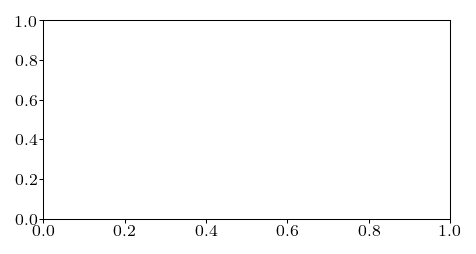

In [14]:
def plot_over_time_si_no_manual(*, country, area, quantity, mode, beacon_proportion, p_adoption=0.25, ymax, 
                                  rt_plots=True, commithash=None):

    p_recall = 0.1
    p_manual_reachability = 0.5
    delta_manual_tracing = 0.0
    show_spect_with_beacons = False
    beacon_mode = 'visit_freq'

    
    paths = [f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall=0.0'
                     f'-p_manual_reachability=0.0'
                     f'-delta_manual_tracing=0.0'
                     f'.pk',
             
             f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     f'-delta_manual_tracing={delta_manual_tracing}'
                     f'.pk'
        
            f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
                 f'spect-tracing-{country}-{area}'
                 f'-p_adoption={p_adoption}'
                 f'-p_recall=0.0'
                 f'-p_manual_reachability=0.0'
                 f'-delta_manual_tracing=0.0'
                 '.pk',
            
            f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
                 f'spect-tracing-{country}-{area}'
                 f'-p_adoption={p_adoption}'
                 f'-p_recall={p_recall}'
                 f'-p_manual_reachability={p_manual_reachability}'
                 f'-delta_manual_tracing={delta_manual_tracing}'
                 '.pk',
            
            f'PanCast/pancast-tracing-{country}-{area}'
              f'-p_adoption={p_adoption}'
              f'-beacon_proportion={beacon_proportion}'
              f'-beacon_mode={beacon_mode}'
              f'-p2p_beacon={show_spect_with_beacons}'
              f'-p_recall=0.0'
              f'-p_manual_reachability=0.0'
              f'-delta_manual_tracing=0.0'
              '.pk',
            
            f'PanCast/pancast-tracing-{country}-{area}'
              f'-p_adoption={p_adoption}'
              f'-beacon_proportion={beacon_proportion}'
              f'-beacon_mode={beacon_mode}'
              f'-p2p_beacon={show_spect_with_beacons}'
              f'-p_recall={p_recall}'
              f'-p_manual_reachability={p_manual_reachability}'
              f'-delta_manual_tracing={delta_manual_tracing}'
              '.pk']
    
    labels = ['Baseline without MT',
              'Baseline with MT',
              'SPECTS without MT',
              'SPECTS with MT',
              f'PanCast, {int(beacon_proportion*100)}\% beacons, without MT'
              f'PanCast, {int(beacon_proportion*100)}\% beacons, with MT'
             ]
    
    plot_filename = f'si-no-manual-{mode}-{quantity}_over_time-{country}-{area}'
    plotter = Plotter()

    plotter.compare_quantity(
        paths, 
        titles=labels,
        quantity=quantity,
        mode=mode,
        ymax=ymax,
        filename=plot_filename, 
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figformat='neurips-double',
        legend_is_left=True)
    
    if rt_plots and quantity=='infected':
        for i, (path, label) in enumerate(zip(paths, labels)):
            plot_filename = 'rt-no-manual' + label

            # plot
            plotter = Plotter()
            plotter.plot_daily_nbinom_rts(
                path=path, 
                filename=plot_filename,
                cmap_range=(0.5, 1.5),
                figsize=lib_plot.FIG_SIZE_NEURIPS_TRIPLE,
                figformat='neurips-double',
                ymax=3.3,
                label=labels[i],
                #xlim=(0, 185),
                x_axis_dates=False,
                subplots_adjust={'bottom':0.2, 'top': 0.98, 'left': 0.12, 'right': 0.96},
            )
    
    
for quantity in ['infected', 'hosp']:
    plot_over_time_si_no_manual(
        country='GER', 
        area='TU',
        quantity=quantity,    # Allowed values: ['infected', 'hosp', 'dead']
        mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
        ymax=20000, 
        p_adoption=0.25,
        beacon_proportion=0.25,
    )

## SI: Manual tracing delay

Extracting data from summary: PanCast/spect-tracing-GER-TU-None/spect-tracing-GER-TU-p_adoption=0.25-p_recall=0.1-p_manual_reachability=0.5-delta_manual_tracing=0.0.pk


FileNotFoundError: [Errno 2] No such file or directory: 'summaries/PanCast/spect-tracing-GER-TU-None/spect-tracing-GER-TU-p_adoption=0.25-p_recall=0.1-p_manual_reachability=0.5-delta_manual_tracing=0.0.pk'

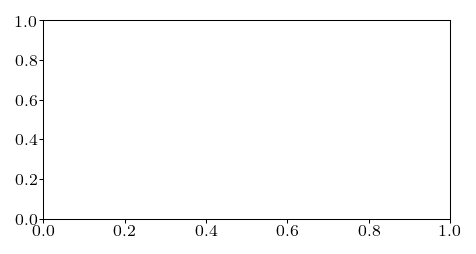

In [20]:
def plot_over_time_si_mt_delay(*, country, area, quantity, mode, manual_tracing_delays,
                               beacon_proportion, p_adoption=0.25, ymax=None, rt_plots=True, commithash=None):

    p_recall = 0.1
    p_manual_reachability = 0.5
    show_spect_with_beacons = False
    beacon_mode = 'visit_freq'

    paths = []
    labels = []
    
    for delta_manual_tracing in manual_tracing_delays:


        paths.append(f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption={p_adoption}'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     f'-delta_manual_tracing={delta_manual_tracing}'
                     '.pk')
    
        labels = [f'SPECTS, {int(delta_manual_tracing)}h delay']
    
    for delta_manual_tracing in manual_tracing_delays:
        paths.append(f'PanCast/pancast-tracing-{country}-{area}'
              f'-p_adoption={p_adoption}'
              f'-beacon_proportion={beacon_proportion}'
              f'-beacon_mode={beacon_mode}'
              f'-p2p_beacon={show_spect_with_beacons}'
              f'-p_recall={p_recall}'
              f'-p_manual_reachability={p_manual_reachability}'
              f'-delta_manual_tracing={delta_manual_tracing}'
              '.pk')
        
        labels.append(f'PanCast, {int(beacon_proportion*100)}\% beacons, {int(delta_manual_tracing)}h delay')
    
    plot_filename = f'si-manual-delay-{mode}-{quantity}_over_time-{country}-{area}'
    plotter = Plotter()

    plotter.compare_quantity(
        paths, 
        titles=labels,
        quantity=quantity,
        mode=mode,
        ymax=ymax,
        filename=plot_filename, 
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figformat='neurips-double',
        legend_is_left=True)
    
    if rt_plots and quantity=='infected':
        for i, (path, label) in enumerate(zip(paths, labels)):
            plot_filename = 'rt-mt-delay' + label

            # plot
            plotter = Plotter()
            plotter.plot_daily_nbinom_rts(
                path=path, 
                filename=plot_filename,
                cmap_range=(0.5, 1.5),
                figsize=lib_plot.FIG_SIZE_NEURIPS_TRIPLE,
                figformat='neurips-double',
                ymax=3.3,
                label=labels[i],
                #xlim=(0, 185),
                x_axis_dates=False,
                subplots_adjust={'bottom':0.2, 'top': 0.98, 'left': 0.12, 'right': 0.96},
            )
    
    
    
for quantity in ['infected', 'hosp']:
    plot_over_time_si_mt_delay(
        country='GER', 
        area='TU',
        quantity=quantity,    # Allowed values: ['infected', 'hosp', 'dead']
        mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
        ymax=20000, 
        manual_tracing_delays=[0.0, 12.0, 24.0],
        p_adoption=0.25,
        beacon_proportion=0.25,
    )

## SI: Interoperability

Extracting data from summary: PanCast/spect-tracing-GER-TU-None/spect-tracing-GER-TU-p_adoption=0.0-p_recall=0.1-p_manual_reachability=0.5-delta_manual_tracing=0.0.pk


FileNotFoundError: [Errno 2] No such file or directory: 'summaries/PanCast/spect-tracing-GER-TU-None/spect-tracing-GER-TU-p_adoption=0.0-p_recall=0.1-p_manual_reachability=0.5-delta_manual_tracing=0.0.pk'

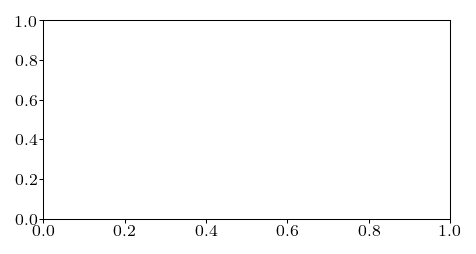

In [33]:
def plot_over_time_si_interoperability(*, country, area, quantity, mode,
                                      beacon_proportion, p_adoption=0.25, ymax=None, rt_plots=True,
                                       commithash=None):


    p_recall = 0.1
    p_manual_reachability = 0.5
    delta_manual_tracing = 0.0
    show_spect_with_beacons = False
    beacon_mode = 'visit_freq'

    paths = [
        # Baseline with MT
        f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     f'-delta_manual_tracing={delta_manual_tracing}'
                     f'.pk',
        
        # PanCast
        f'PanCast/pancast-tracing-{country}-{area}'
              f'-p_adoption={p_adoption}'
              f'-beacon_proportion={beacon_proportion}'
              f'-beacon_mode={beacon_mode}'
              f'-p2p_beacon=False'
              f'-p_recall={p_recall}'
              f'-p_manual_reachability={p_manual_reachability}'
              f'-delta_manual_tracing={delta_manual_tracing}'
              '.pk',
        
        # SPECTS
        f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption={p_adoption}'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     f'-delta_manual_tracing={delta_manual_tracing}'
                     '.pk',
        
        # SPECTS + beacons
        f'PanCast/pancast-tracing-{country}-{area}'
              f'-p_adoption={p_adoption}'
              f'-beacon_proportion={beacon_proportion}'
              f'-beacon_mode={beacon_mode}'
              f'-p2p_beacon=True'
              f'-p_recall={p_recall}'
              f'-p_manual_reachability={p_manual_reachability}'
              f'-delta_manual_tracing={delta_manual_tracing}'
              '.pk',
    ]
    
    labels = ['Baseline with MT',
             'SPECTS',
             f'PanCast, {int(beacon_proportion*100)}\% beacons',
             f'SPECTS + {int(beacon_proportion*100)}\% beacons',
             ]
    

    plot_filename = f'si-interoperability-{mode}-{quantity}_over_time-{country}-{area}'
    plotter = Plotter()

    plotter.compare_quantity(
        paths, 
        titles=labels,
        quantity=quantity,
        mode=mode,
        ymax=ymax,
        filename=plot_filename, 
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figformat='neurips-double',
        legend_is_left=True)
    
    if rt_plots and quantity=='infected':
        for i, (path, label) in enumerate(zip(paths, labels)):
            plot_filename = 'rt-interoperation' + label

            # plot
            plotter = Plotter()
            plotter.plot_daily_nbinom_rts(
                path=path, 
                filename=plot_filename,
                cmap_range=(0.5, 1.5),
                figsize=lib_plot.FIG_SIZE_NEURIPS_TRIPLE,
                figformat='neurips-double',
                ymax=3.3,
                label=labels[i],
                #xlim=(0, 185),
                x_axis_dates=False,
                subplots_adjust={'bottom':0.2, 'top': 0.98, 'left': 0.12, 'right': 0.96},
            )
    
    
    
for quantity in ['infected', 'hosp']:
    plot_over_time_si_interoperability(
        country='GER', 
        area='TU',
        quantity=quantity,    # Allowed values: ['infected', 'hosp', 'dead']
        mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
        ymax=20000, 
        p_adoption=0.25,
        beacon_proportion=0.25,
    )

In [ ]:
# Crop pdf margins
!bash crop_pdfs.sh plots/daily-nbinom-rts-*.pdf
!bash crop_pdfs.sh plots/prob-secondaryCases-*.pdf

## ROC

None
Loaded previously extracted data.
[-0.01, 0.0, 0.01, 0.019999999999999997, 0.03, 0.04, 0.049999999999999996, 0.060000000000000005, 0.07, 0.08, 0.09000000000000001, 0.1, 0.11, 0.12000000000000001, 0.13, 0.13999999999999999, 0.15, 0.16, 0.16999999999999998, 0.18, 0.19, 0.19999999999999998, 0.21, 0.22, 0.22999999999999998, 0.24, 0.25, 0.26, 0.27, 0.27999999999999997, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.8200000000000001, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01]
[1.0, 0.9999659696108625, 0.8571914719844821, 0.7741062769052763, 0.7036974017797893, 0.640588045124296, 0.5785676609212026, 0.520103452382978, 0.4635279304

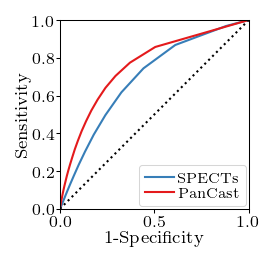

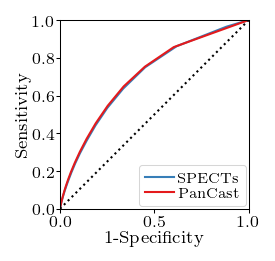

In [44]:
def plot_roc(*, country, area, p_adoption, p_beacon, beta_dispersions, manual_tracing, sitetype=None, 
             multiplot=False, commithash=None):
    
    for beta_dispersion in beta_dispersions:
        path = (f'PanCast/beacon-environment-{country}-{area}-{commithash}/'
                          f'beacon-environment-{country}-{area}'
                          f'-beacon=all'
                          f'-p_adoption=1.0'
                          f'-beta_dispersion={beta_dispersion}'
                          '.pk')

        if p_adoption is not None:
            if manual_tracing:
                p_manual_reachability = 0.5
                p_recall = 0.1
            else:
                p_manual_reachability = 0.0
                p_recall = 0.0
        else:
            p_manual_reachability = None
            p_recall = None
            p_beacon = None
            p_adoption = [None]

        if multiplot:
            figsize = (8,3)
            ps_adoption = [p_adoption]
        else:
            figsize = (2.0, 1.8)
            ps_adoption = p_adoption
            
        for p_adoption in ps_adoption:
            print(p_adoption)
            plot_filename = f'ROC-{country}-{area}-p_adoption={p_adoption}-p_beacon={p_beacon}-manual-tracing={manual_tracing}-beta-dispersion={beta_dispersion}'
            plotter = Plotter()

            plotter.plot_roc_curve(
                summaries=None,
                paths=[path],
                filename=plot_filename, 
                p_adoption=p_adoption,
                p_manual_reachability=p_manual_reachability,
                p_recall=p_recall,
                p_beacon=p_beacon,
                sitetype=sitetype,
                action='isolate',
                figsize=figsize, 
    #             figsize=(1.8, 1.6), 
                figformat='neurips-double',
                verbose=False,
                use_medical_labels=True)

    
plot_roc(
    country='GER', 
    area='TU', 
    p_adoption=None,
    p_beacon=None,
    sitetype=None,
    beta_dispersions=[10.0, 'custom'],
    manual_tracing=True,
    multiplot=False,
    commithash='baf7764'
)

# plot_roc(
#     country='GER', 
#     area='TU', 
#     p_adoption=[0.5, 0.25, 0.1, 0.05],
#     p_beacon=[0.5, 0.25, 0.1, 0.05],
#     beta_dispersions=[10.0],
#     manual_tracing=True,
#     multiplot=True,
#     commithash='baf7764'
# )
    


In [42]:
# plot_roc(
#     country='GER', 
#     area='TU', 
#     p_adoption=None,
#     p_beacon=None,
#     sitetype=None,
#     beta_dispersions=[10.0, 'custom'],
#     manual_tracing=True,
#     multiplot=False,
#     commithash='9ee166f')

In [ ]:
[-0.01, 0.0, 0.01, 0.019999999999999997, 0.03, 0.04, 0.049999999999999996, 0.060000000000000005, 0.07, 0.08, 0.09000000000000001, 0.1, 0.11, 0.12000000000000001, 0.13, 0.13999999999999999, 0.15, 0.16, 0.16999999999999998, 0.18, 0.19, 0.19999999999999998, 0.21, 0.22, 0.22999999999999998, 0.24, 0.25, 0.26, 0.27, 0.27999999999999997, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.8200000000000001, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01]

In [49]:
from tabulate import tabulate

Loaded previously extracted data.


In [50]:
thresholds = [-0.01, 0.0, 0.01, 0.019999999999999997, 0.03, 0.04, 0.049999999999999996, 0.060000000000000005, 0.07, 0.08, 0.09000000000000001, 0.1, 0.11, 0.12000000000000001, 0.13, 0.13999999999999999, 0.15, 0.16, 0.16999999999999998, 0.18, 0.19, 0.19999999999999998, 0.21, 0.22, 0.22999999999999998, 0.24, 0.25, 0.26, 0.27, 0.27999999999999997, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.8200000000000001, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01]

In [106]:
beta_dispersion = 'custom'
summary = load_condensed_summary(f'PanCast/beacon-environment-GER-TU-baf7764/'
                          f'beacon-environment-GER-TU'
                          f'-beacon=all'
                          f'-p_adoption=1.0'
                          f'-beta_dispersion={beta_dispersion}'
                          '.pk')
print()

tracing_stats = summary['tracing_stats']


thres = thresholds[3]

betas = {'custom': {'sites': {'total': 0, 'education': 0.02731594725044837, 'social': 0.05463189450089674, 'bus_stop': 0.0018210631500298917, 'office': 0.03642126300059783, 'supermarket': 0.018210631500298915},
                    'no_sites': {'total': 0, 'education': 0.04027511551976204, 'social': 0.04027511551976204, 'bus_stop': 0.04027511551976204, 'office': 0.04027511551976204, 'supermarket': 0.04027511551976204}
                    },
         10.0: {'no_sites': {'total': 0, 'education': 0.04027511551976204, 'social': 0.04027511551976204, 'bus_stop': 0.04027511551976204, 'office': 0.04027511551976204, 'supermarket': 0.04027511551976204},
                'sites': {'total': 0, 'education': 0.008195195098129743, 'social': 0.08195195098129741, 'bus_stop': 0.0008195195098129743, 'office': 0.008195195098129743, 'supermarket': 0.008195195098129743}
                }
        }

betas = betas[beta_dispersion]

print()
print('Threshold: ', thres)
for sites in ['no_sites', 'sites']:
    values = []
    print()
    if sites == 'no_sites':
        print('SPECTS')
    else:
        print('PanCast')
    print()
    for sitetype in tracing_stats[thres].keys():
        infected = tracing_stats[thres][sitetype][sites]['isolate']['tp'].mean() + tracing_stats[thres][sitetype][sites]['isolate']['fn'].mean()
        not_infected = tracing_stats[thres][sitetype][sites]['isolate']['tn'].mean() + tracing_stats[thres][sitetype][sites]['isolate']['fp'].mean()
        isolated = tracing_stats[thres][sitetype][sites]['isolate']['tp'].mean() + tracing_stats[thres][sitetype][sites]['isolate']['fp'].mean()
        not_isolated = tracing_stats[thres][sitetype][sites]['isolate']['fn'].mean() + tracing_stats[thres][sitetype][sites]['isolate']['tn'].mean()
        tpr = tracing_stats[thres][sitetype][sites]['isolate']['tp'].mean() / infected
        fpr = tracing_stats[thres][sitetype][sites]['isolate']['fp'].mean() / not_infected
    
        if sitetype == 'stats':
            sitetype = 'total'
        values.append([sitetype, "{:.4f}".format(betas[sites][sitetype]), int(infected), int(not_infected), int(isolated), tpr, fpr])
    print(tabulate(values, headers=['Sitetype', 'beta', 'infected', 'not infected', 'isolated', 'TPR', 'FPR']))

Loaded previously extracted data.


Threshold:  0.019999999999999997

SPECTS

Sitetype       beta    infected    not infected    isolated         TPR         FPR
-----------  ------  ----------  --------------  ----------  ----------  ----------
education    0.0403         223           16262        9792  0.802127    0.591105
social       0.0403         426           30957       13922  0.729913    0.43967
bus_stop     0.0403           6            2242           5  0.00721501  0.00229212
office       0.0403         163            9629        5954  0.84693     0.603998
supermarket  0.0403          23            6397         510  0.160489    0.0791853
total        0              844           65489       30185  0.749769    0.451244

PanCast

Sitetype       beta    infected    not infected    isolated        TPR          FPR
-----------  ------  ----------  --------------  ----------  ---------  -----------
education    0.0273         223           16262        7820  0.712818   0.471117
s

Loaded previously extracted data.



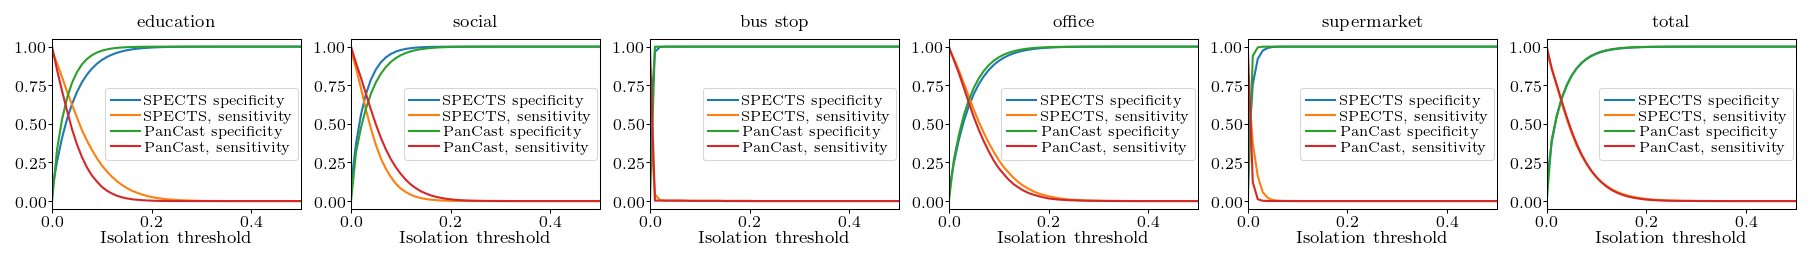

In [121]:
from collections import defaultdict

beta_dispersion = 'custom'
summary = load_condensed_summary(f'PanCast/beacon-environment-GER-TU-baf7764/'
                          f'beacon-environment-GER-TU'
                          f'-beacon=all'
                          f'-p_adoption=1.0'
                          f'-beta_dispersion={beta_dispersion}'
                          '.pk')
print()

tracing_stats = summary['tracing_stats']


results = {'sites': defaultdict(lambda: {'fpr': [], 'tpr': []}),
          'no_sites': defaultdict(lambda: {'fpr': [], 'tpr': []})}

for sites in ['no_sites', 'sites']:
    for sitetype in tracing_stats[thres].keys():
        for thres in thresholds:
            infected = tracing_stats[thres][sitetype][sites]['isolate']['tp'].mean() + tracing_stats[thres][sitetype][sites]['isolate']['fn'].mean()
            not_infected = tracing_stats[thres][sitetype][sites]['isolate']['tn'].mean() + tracing_stats[thres][sitetype][sites]['isolate']['fp'].mean()
            isolated = tracing_stats[thres][sitetype][sites]['isolate']['tp'].mean() + tracing_stats[thres][sitetype][sites]['isolate']['fp'].mean()
            not_isolated = tracing_stats[thres][sitetype][sites]['isolate']['fn'].mean() + tracing_stats[thres][sitetype][sites]['isolate']['tn'].mean()
            tpr = tracing_stats[thres][sitetype][sites]['isolate']['tp'].mean() / infected
            fpr = tracing_stats[thres][sitetype][sites]['isolate']['fp'].mean() / not_infected
            results[sites][sitetype]['fpr'].append(fpr)
            results[sites][sitetype]['tpr'].append(tpr)

sitetype = 'education'
fig, ax = plt.subplots(1, len(tracing_stats[0.0].keys()), figsize=(15,1.5))
for i, sitetype in enumerate(tracing_stats[thres].keys()):
    for sites in ['no_sites', 'sites']:
        label = 'PanCast' if sites=='sites' else 'SPECTS'
        ax[i].plot(thresholds, 1- np.asarray(results[sites][sitetype]['fpr']), label=label+' specificity')
        ax[i].plot(thresholds, results[sites][sitetype]['tpr'], label=label+', sensitivity')
        ax[i].set_xlim([0,0.5])
        title = 'bus stop' if sitetype == 'bus_stop' else sitetype
        title = 'total' if sitetype == 'stats' else title
        ax[i].set_title(title)
        ax[i].set_xlabel('Isolation threshold')
        ax[i].legend()
filename = f'site-dependent-characteristics-beta_dispersion={beta_dispersion}'
plt.savefig('plots/' + filename + '.pdf', format='pdf', facecolor=None,
                    dpi=200, bbox_inches='tight')

    


    


In [ ]:
# Crop pdf margins
# !bash crop_pdfs.sh plots/beacon-environment-*.pdf


In [222]:
# plots = {
#          f'beacon-environment-GER-TU-beta_dispersion=20.0' : [
#             Plot(label='tracing-stats', 
#                 path=(f'PanCast/beacon-environment-GER-TU-9ee166f/'
#                       f'beacon-environment-GER-TU'
#                       f'-beacon=all'
#                       f'-p_adoption=1.0'
#                       f'-beta_dispersion=20.0'
#                       '.pk')),
#          ]
#     }
    
# for plot_filename, plots in plots.items():
#     # extract plot info
#     labels = get_properties(plots, 'label')
#     paths = get_properties(plots, 'path')
# summary = load_condensed_summary(paths[0])
# summary['tracing_stats']

# Heat maps

In [ ]:
def plot_relative_quantity_heatmap_beacon_mode(*, country, area, mode,
    ps_adoption, beta_dispersion, beacon_proportions, 
    p_recall, interpolate, cmap):
    
    filename = (
        f'relative-{mode}-heatmap-pancast'
    )
    
    baseline_path = (
        f'spect-tracing-{country}-{area}-{commithash}/'
        f'spect-tracing-{country}-{area}'
        f'-p_adoption=0.0'
        f'-beta_dispersion={beta_dispersion}.pk')
    
    # pair of list of tuples (x, y, path)
    paths = (
        # spect
        [(beacon_proportion, p_adoption, 
         (f'pancast-tracing-{country}-{area}-{commithash}/'
          f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-p_recall={p_recall}'
          f'-beacon_proportion={beacon_proportion}'
          f'-beacon_mode=random'
          f'-beta_dispersion={beta_dispersion}'
          '.pk'))
        for p_adoption in ps_adoption
        for beacon_proportion in beacon_proportions],
        
        # pancast
        [(beacon_proportion, p_adoption, 
         (f'pancast-tracing-{country}-{area}-{commithash}/'
          f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-p_recall={p_recall}'
          f'-beacon_proportion={beacon_proportion}'
          f'-beacon_mode=visit_freq'
          f'-beta_dispersion={beta_dispersion}'
          '.pk'))
        for p_adoption in ps_adoption
        for beacon_proportion in beacon_proportions]
    )

    # plots
    plotter = Plotter()
    plotter.relative_quantity_heatmap(
        xlabel=r'\% sites with beacon',
        ylabel=r'\% adoption',
        path_labels=['placed randomly', 'by integr. visit time'],
        paths=paths, 
        mode=mode,
        baseline_path=baseline_path,
        filename=filename, 
#         figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figsize=(4.0, 2.0), 
        figformat='neurips-double',
        interpolate=interpolate,
        width_ratio=1,
        cmap=cmap,
    )

    
for mode in ["cumu_infected", "hosp"]:
    plot_relative_quantity_heatmap_beacon_mode(
        mode=mode,
        country='GER', 
        area='TU', 
        ps_adoption=[0.1, 0.25, 0.5, 1.0],
        beta_dispersion=1.0,
        beacon_proportions=[1.0, 0.25, 0.1, 0.05, 0.02],
        p_recall=0.1,
        interpolate='linear',
        cmap=plt.cm.RdYlGn,
    )
        

In [ ]:
!bash crop_pdfs.sh plots/relative-*.pdf


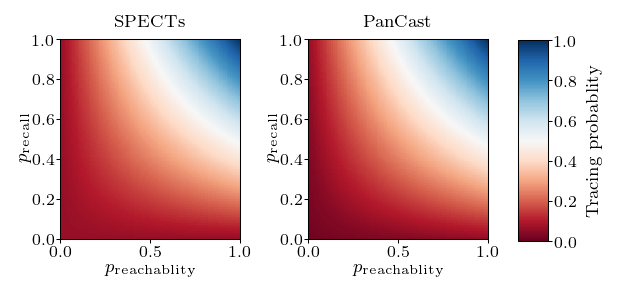

In [480]:
def plot_tracing_probability(mode, p_adoption, p_beacon):
    fig, axs = plt.subplots(1,2, figsize=(4,2))

    p_recall, p_manually_reachable = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

    for k, system in enumerate(['SPECTs', 'PanCast']):
        p_tracable = get_tracing_probability(system, p_adoption=p_adoption, p_manual_reachability=p_manually_reachable, p_recall=p_recall, p_beacon=p_beacon)
        p_tracable_min, p_tracable_max = 0.0, 1.0

        c = axs[k].pcolormesh(p_manually_reachable, p_recall, p_tracable, cmap='RdBu', vmin=p_tracable_min, vmax=p_tracable_max)
        axs[k].set_title(system)
        axs[k].set_ylabel(r'$p_{\rm recall}$')
        axs[k].set_xlabel(r'$p_{\rm reachablity}$')

    fig.tight_layout()
    fig.subplots_adjust(right=0.82)

    cbar_ax = fig.add_axes([0.87, 0.18, 0.05, 0.67])
    cbar = matplotlib.colorbar.ColorbarBase(
        cbar_ax, cmap=plt.cm.RdBu,
        norm=colors.Normalize(vmin=0, vmax=1),
        orientation='vertical')
    cbar.set_label('Tracing probablity', labelpad=5.0)

    plt.show()
    
plot_tracing_probability(mode=None, p_adoption=0.25, p_beacon=0.25)

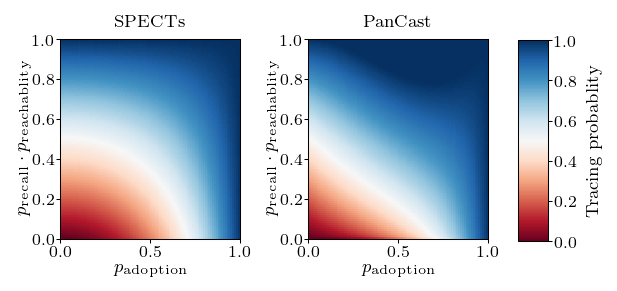

In [483]:
def plot_tracing_probability2(mode, p_beacon):
    fig, axs = plt.subplots(1,2, figsize=(4,2))

    p_recall_reachability, p_adoption = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

    for k, system in enumerate(['SPECTs', 'PanCast']):
        p_recall = np.sqrt(p_recall_reachability)
        p_reachable = np.sqrt(p_recall_reachability)
        p_tracable = get_tracing_probability(system, p_adoption=p_adoption, p_manual_reachability=p_reachable, p_recall=p_recall, p_beacon=p_beacon)

        c = axs[k].pcolormesh(p_adoption, p_recall_reachability, p_tracable, cmap='RdBu', vmin=0.0, vmax=1.0)
        axs[k].set_title(system)
        axs[k].set_ylabel(r'$p_{\rm recall} \cdot p_{\rm reachablity}$')
        axs[k].set_xlabel(r'$p_{\rm adoption}$')

    fig.tight_layout()
    fig.subplots_adjust(right=0.82)

    cbar_ax = fig.add_axes([0.87, 0.18, 0.05, 0.67])
    cbar = matplotlib.colorbar.ColorbarBase(
        cbar_ax, cmap=plt.cm.RdBu,
        norm=colors.Normalize(vmin=0, vmax=1),
        orientation='vertical')
    cbar.set_label('Tracing probablity', labelpad=5.0)

    plt.show()
    
plot_tracing_probability2(mode=None, p_beacon=1.0)

In [470]:
p_tracable = get_tracing_probability('PanCast', 
                                     p_adoption=1, 
                                     p_manual_reachability=0.95,
                                     p_recall=0.95, 
                                     p_beacon=0.95)
print(p_tracable)

0.995125


In [130]:
def get_tracing_probability2(mode, p_adoption, p_manual_reachability, p_recall, p_beacon=0.0):
    if mode == 'SPECTs':
        p_digital = p_adoption ** 2
        p_manual = p_recall * p_manual_reachability * (1 - p_digital)
        p_tracing = p_digital + p_manual
    elif mode == 'PanCast':
        p_digital = (p_adoption ** 2) * p_beacon
        p_manual = p_recall * p_manual_reachability * (1 - p_digital)
        p_digital_manual = p_beacon * p_adoption * p_manual_reachability * (1 - p_adoption) * (1 - p_digital) * (1 - p_manual)
        p_manual_digital = p_beacon * p_adoption * p_recall * (1 - p_adoption) * (1 - p_digital) * (1 - p_manual) * (1 - p_digital_manual)
        p_tracing = p_digital + p_digital_manual + p_manual_digital + p_manual
        print(p_digital, p_digital_manual, p_manual_digital, p_manual)
    else:
        NotImplementedError('`mode` can only be in ["SPECTs", "PanCast"]')
    return p_tracing


p_tracable = get_tracing_probability2('PanCast', 
                                     p_adoption=0.8, 
                                     p_manual_reachability=0.99,
                                     p_recall=0.99, 
                                     p_beacon=0.8)
print(p_tracable)

0.5120000000000001 0.032262286712832 0.031221431568891025 0.47828879999999985
1.053772518281723
